In [1]:
import glob
import os
import time
import random
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

2024-01-28 22:04:09.334527: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-28 22:04:09.368986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 22:04:09.369015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 22:04:09.370101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 22:04:09.375655: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-28 22:04:09.376983: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
EPOCHS = 100
BATCH_SIZE = 4
BUFFER_SIZE = 14224
LAMBDA = 100

CONVERT_RGB = True

IMG_WIDTH = 512
IMG_HEIGHT = 512

TRAIN_DATASET_SKETCHES = 'data/sketches2/train'
TRAIN_DATASET_PHOTOS = 'data/images/train'

TEST_DATASET_SKETCHES = 'data/sketches2/test'
TEST_DATASET_PHOTOS = 'data/images/test'

VAL_DATASET_SKETCHES = 'data/sketches2/val'
VAL_DATASET_PHOTOS = 'data/images/val'

LOG_FOLDER = 'logs2'

## Carga de imágenes

In [4]:
def load_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image)
    image = tf.cast(image, tf.float32)
    
    return image

def load_gray_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image)
    image = tf.cast(image, tf.float32)

    if CONVERT_RGB:
        image = tf.image.grayscale_to_rgb(image)
    
    return image


def normalize_image(image):
    image = (image / 127.5) - 1     # Normalizar las imágenes al rango [-1, 1] 
                                    # (dividiento por 127.5 lo llevamos al rango [0,2] y restando 1 lo llevamos a [-1,1])
    return image


def create_dataset(sketches_path, photos_path, pattern='*.png'):

    # Paths completos de cada imagen (foto o sketch)
    sketches_images_path = glob.glob(os.path.join(sketches_path, pattern))
    photos_images_path = [os.path.join(photos_path, os.path.basename(ruta)) for ruta in sketches_images_path]

    # Leer los paths y cargar las imagenes (fotos o sketch)
    sketches_images = tf.data.Dataset.from_tensor_slices(sketches_images_path).map(load_gray_image).map(normalize_image)
    photos_images = tf.data.Dataset.from_tensor_slices(photos_images_path).map(load_image).map(normalize_image)
    
    # Agrupar fotos y sketches por lotes y desordenar el dataset
    dataset = tf.data.Dataset.zip((sketches_images, photos_images))
    if sketches_path == VAL_DATASET_SKETCHES or photos_path == VAL_DATASET_PHOTOS:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(1)
    else:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    
    return dataset   

In [5]:
train_dataset = create_dataset(TRAIN_DATASET_SKETCHES, TRAIN_DATASET_PHOTOS)
test_dataset = create_dataset(TEST_DATASET_SKETCHES, TEST_DATASET_PHOTOS)

2024-01-28 22:04:22.330932: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 22:04:22.331527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 22:04:22.332091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Construcción del modelo

### Capas de encoder (downsampling) y decoder (upsampling)

In [6]:
def encoder_layer(filters, size, batchnorm=True):

    # Capa de convolucion que reduce el tamaño a la mitad (stride=2)
    layer_ = keras.layers.Conv2D(
        filters=filters, 
        kernel_size=size, 
        strides=2, 
        padding='same', 
        kernel_initializer=tf.random_normal_initializer(0., 0.02), 
        use_bias=False)
    
    # Batch normalization 
    batch_norm_ = keras.layers.BatchNormalization() 
    
    # Leaky ReLU para activación en downsample
    # # Prevención de Neuronas "Muertas", 
    # Mejora del Gradiente durante el Backpropagation, 
    # Robustez en la Extracción de Características
    activation_ = keras.layers.LeakyReLU()

    return keras.Sequential(
        [layer_, batch_norm_, activation_] if batchnorm else [layer_, activation_]
        )
    
    
def decoder_layer(filters, size, dropout=False):
    
    # Capa de convolucion transpuesta que aumenta el tamaño a la mitad (stride=2)
    layer_ = keras.layers.Conv2DTranspose(
        filters=filters, 
        kernel_size=size, 
        strides=2, 
        padding='same', 
        kernel_initializer=tf.random_normal_initializer(0., 0.02), 
        use_bias=False)
    
    # Batch normalization
    batch_norm_ = keras.layers.BatchNormalization()
    
    # Dropout
    dropout_ = keras.layers.Dropout(0.5)
    
    # ReLU para activación en upsample
    activation_ = keras.layers.ReLU()
    
    return keras.Sequential(
        [layer_, batch_norm_, dropout_, activation_] if dropout else [layer_, batch_norm_, activation_]
        )
    
    
def simple_conv_layer(filters, size):
    
    # Capa de convolucion
    layer_ = keras.layers.Conv2D(
        filters=filters, 
        kernel_size=size, 
        strides=1, 
        padding='same', 
        kernel_initializer=tf.random_normal_initializer(0., 0.02), 
        use_bias=False)
    
    # Batch normalization
    batch_norm_ = keras.layers.BatchNormalization()
    
    # Leaky ReLU para activación
    activation_ = keras.layers.LeakyReLU()
    
    return keras.Sequential( [layer_, batch_norm_, activation_] )

### Generador (arquitectura UNET)

In [7]:
class Generator(keras.Model):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        # Downsampling o capas de codificacion (reducen el tamano de la imagen)
        # Compuestas por varios bloques del tipo Convolucion -> Normalizacion de batch -> Leaky Relu
        self.encoder_block = [
            encoder_layer(64, 4, batchnorm=False), # (bs, 256, 256, 64)
            encoder_layer(128, 4), # (bs, 128, 128, 128)
            encoder_layer(256, 4), # (bs, 64, 64, 256)
            encoder_layer(512, 4), # (bs, 32, 32, 512)
            encoder_layer(512, 4), # (bs, 16, 16, 512)
            encoder_layer(512, 4), # (bs, 8, 8, 512)
            encoder_layer(512, 4), # (bs, 4, 4, 512)
            encoder_layer(512, 4), # (bs, 2, 2, 512)
            encoder_layer(512, 4) # (bs, 1, 1, 512)
        ]
        
        # Upsampling o capas de decodificacion 
        # Compuestos por bloques de Convolucion inversa -> Normalizacion de batch -> Dropout -> Relu
        self.decoder_block = [
            decoder_layer(512, 4, dropout=True), # (bs 2, 2, 512) --> (bs, 2, 2, 1024)
            decoder_layer(512, 4, dropout=True), # (bs, 4, 4, 512) --> (bs, 4, 4, 1024)
            decoder_layer(512, 4, dropout=True), # (bs, 8, 8, 512) --> (bs, 8, 8, 1024)
            decoder_layer(512, 4), # (bs, 16, 16, 512) --> (bs, 16, 16, 1024)
            decoder_layer(512, 4), # (bs, 32, 32, 512) --> (bs, 32, 32, 1024)
            decoder_layer(256, 4), # (bs, 64, 64, 256) --> (bs, 64, 64, 512)
            decoder_layer(128, 4), # (bs, 128, 128, 128) --> (bs, 128, 128, 256)
            decoder_layer(64, 4) # (bs, 256, 256, 64) --> (bs, 256, 256, 128)          
        ]

        self.last_layer = keras.layers.Conv2DTranspose(
            filters=3,
            kernel_size=4,
            strides=2,
            padding='same',
            kernel_initializer=tf.random_normal_initializer(0., 0.02),
            activation='tanh') # (bs, 512, 512, 3)

        
    def call(self, sketch_image):
        # Conexion de capas segun arquitectura U-Net
        
        x = sketch_image
        
        down_layers_outputs = []
        for down_layer in self.encoder_block:
            x = down_layer(x)
            down_layers_outputs.append(x)
            
        
        for down_layers_output, up_layer in zip(down_layers_outputs[-2::-1], self.decoder_block):
            x = up_layer(x)
            x = keras.layers.Concatenate()([x, down_layers_output])

        x = self.last_layer(x)
        generated_image = x

        return generated_image

### Discriminador

In [8]:

class Discriminator(keras.Model):
    
    def __init__(self):
            
        super(Discriminator, self).__init__()
        
        
        # Downsampling reduciendo la dimensionalidad
        # Compuesto por bloques de Convolucion -> Normalizacion de batch -> Leaky Relu
        self.encoder_block = [
            encoder_layer(64, 4, batchnorm=False), # (bs, 256, 256, 64)
            encoder_layer(128, 4), # (bs, 128, 128, 128)
            encoder_layer(256, 4), # (bs, 64, 64, 256)
            encoder_layer(512, 4) # (bs, 32, 32, 512)
        ]
        
        # Capa de convolucion simple        
        self.simple_conv_layer = simple_conv_layer(512, 4) # (bs, 29, 29, 512)
        
        # Capa de salida: convolucion final, devuelve un mapa de caracteristicas
        # que cuantifica como de distinta es la imagen generada de la real        
        self.last_layer = keras.layers.Conv2D(
            filters=1,
            kernel_size=4,
            strides=1,
            padding='same',
            kernel_initializer=tf.random_normal_initializer(0., 0.02),
            activation='sigmoid')            # (bs, 26, 26, 1)
        
    def call(self, input_pair):
        
        generated_image, image_to_compare = input_pair        
        x =  keras.layers.Concatenate()([generated_image, image_to_compare])
        
        for down_layer in self.encoder_block:
            x = down_layer(x)
            
        x = self.simple_conv_layer(x)
        x = self.last_layer(x)
        
        features_map = x
        return features_map    

In [9]:

class GAN(keras.Model):
    
    def __init__(self, generator_model, discriminator_model, lambda_val=LAMBDA):
        
        super(GAN, self).__init__()
        self.lambda_val = lambda_val
        self.generator_model = generator_model
        self.discriminator_model = discriminator_model

        
    def compile(self):
        
        super(GAN, self).compile()
        
        self.generator_loss = lambda discriminator_output_generated, generated_image, photo_image: \
            tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(discriminator_output_generated), discriminator_output_generated) + \
            self.lambda_val * tf.reduce_mean(tf.abs(photo_image - generated_image))

        # Definir la función de pérdida del discriminador como una expresión lambda
        self.discriminator_loss = lambda discriminator_output_real, discriminator_output_generated: \
            tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(discriminator_output_real), discriminator_output_real) + \
            tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(discriminator_output_generated), discriminator_output_generated)
        
        self.generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

        
    def train_step(self, data, epoch, batch, log_file=f"{LOG_FOLDER}/models/train_log.txt"):
        
        sketch_image, photo_image = data

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generador: generar una imagen a partir de un sketch
            generated_image = self.generator_model(sketch_image, training=True)

            # Discriminador: distinguir entre la imagen generada y la foto real
            discriminator_output_real = self.discriminator_model([sketch_image, photo_image], training=True)
            discriminator_output_generated = self.discriminator_model([sketch_image, generated_image], training=True)
                
            # Calcula la pérdida del generador
            generator_loss = self.generator_loss(discriminator_output_generated, 
                                        generated_image, 
                                        photo_image)
            discriminator_loss = self.discriminator_loss(discriminator_output_real,
                                                            discriminator_output_generated)
        
        # Backpropagation: calcular gradientes y actualizar pesos
        generator_gradients = gen_tape.gradient(generator_loss, self.generator_model.trainable_variables)
        discriminator_gradients = disc_tape.gradient(discriminator_loss, self.discriminator_model.trainable_variables)
        
        self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator_model.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator_model.trainable_variables))

        with open(log_file, 'a') as f:
            f.write(f"Epoch {epoch}. Batch {batch}. --> Generator loss: {generator_loss.numpy()}, Discriminator loss: {discriminator_loss.numpy()}\n")

    
    
    def save_prediction(self, sketch_image, save_path, photo_image=None):
        if not os.path.exists(os.path.dirname(save_path)):
            os.makedirs(os.path.dirname(save_path))

        # Generar predicción
        generated_image = self.generator_model(sketch_image, training=False)
        plt.figure(figsize=(10, 10))

        if photo_image is not None:
            # Si photo_image está disponible, mostrar las tres imágenes
            images = [sketch_image[0], photo_image[0], generated_image[0]]
            titles = ['Sketch (input)', 'Photo (target/truth)', 'Generated Photo (generation)']
            num_images = 3
        else:
            # Si no, mostrar solo sketch_image y generated_image
            images = [sketch_image[0], generated_image[0]]
            titles = ['Sketch (input)', 'Generated Photo (generation)']
            num_images = 2

        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.title(titles[i])

            plt.imshow(images[i].numpy())  # Para imágenes en el rango [0, 1]
            plt.axis('off')

        plt.savefig(save_path)
        
    
    def fit(self, epochs, train_dataset, val_dataset):
        
        # Seleccionar un subconjunto aleatorio de imagenes para guardar el progreso
        # images_for_progress = random.sample(set(train_dataset), 4)
        images_for_progress = val_dataset.take(4)

        if not os.path.exists(f"{LOG_FOLDER}/models"):
            os.makedirs(f"{LOG_FOLDER}/models")
                
        for epoch in range(epochs):
            print(f"Epoch {epoch}")
            start = time.time()

            # Iterar sobre el conjunto de datos de entrenamiento
            for i, (sketch_image, photo_image) in train_dataset.enumerate():
                self.train_step((sketch_image, photo_image), epoch, i, f"{LOG_FOLDER}/models/train_log.txt")
                
                                
            for i, (sketch_image, photo_image) in enumerate(images_for_progress):
                self.save_prediction(sketch_image, 
                                    f"{LOG_FOLDER}/train_images/comparison_epoch_{epoch}_image_{i}.png",
                                    photo_image
                                    )
                
            with open(f"{LOG_FOLDER}/models/train_log.txt", 'a') as f:
                f.write(f'Time taken for epoch {epoch} is {time.time()-start} sec\n')
                f.write('-------------------------------------------------\n')
            print(f'Time taken for epoch {epoch} is {time.time() - start} sec\n')



    def save_model(self, save_dir):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.generator_model.save_weights(os.path.join(save_dir, 'generator.h5'))
        self.discriminator_model.save_weights(os.path.join(save_dir, 'discriminator.h5'))

## Entrenamiento y evaluacion del modelo

In [10]:
# Cargar imagenes
train_dataset = create_dataset(TRAIN_DATASET_SKETCHES, TRAIN_DATASET_PHOTOS)
test_dataset = create_dataset(TEST_DATASET_SKETCHES, TEST_DATASET_PHOTOS)
val_dataset = create_dataset(VAL_DATASET_SKETCHES, VAL_DATASET_PHOTOS)

In [ ]:
# Ejecutar GAN
generator = Generator()
discriminator = Discriminator()
gan_model = GAN(generator, discriminator)

gan_model.compile()
gan_model.fit(EPOCHS, train_dataset)

In [ ]:
# Guardar modelo
gan_model.save_model(f'{LOG_FOLDER}/models')

In [11]:
# Cargar modelo tras ser entrenado
generator_trained = Generator()
generator_trained.build(input_shape = (None, IMG_WIDTH, IMG_HEIGHT, 3))
generator_trained.load_weights(f'{LOG_FOLDER}/models/generator.h5')

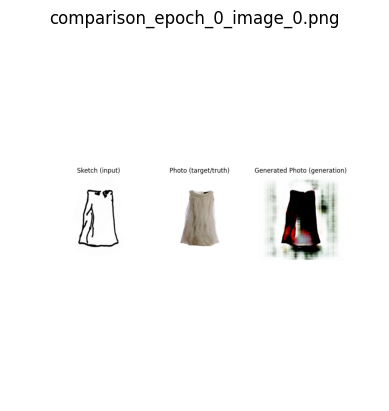

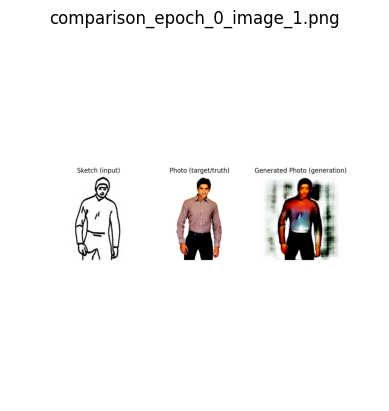

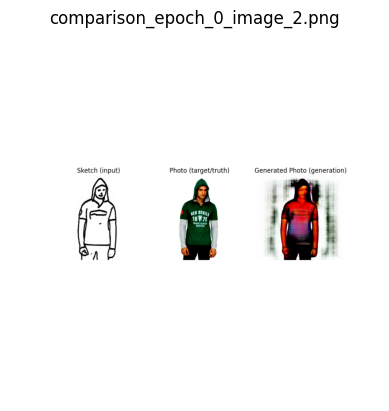

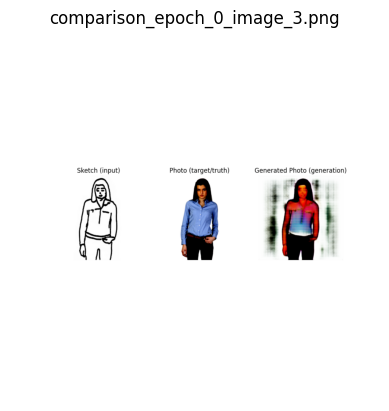

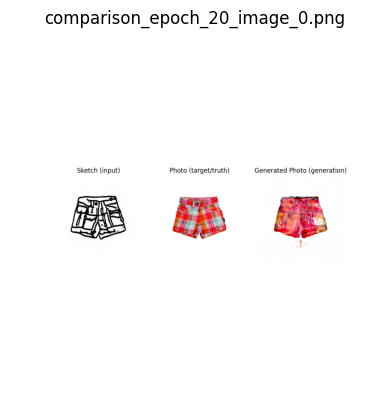

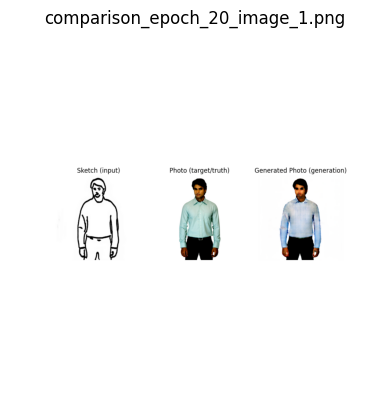

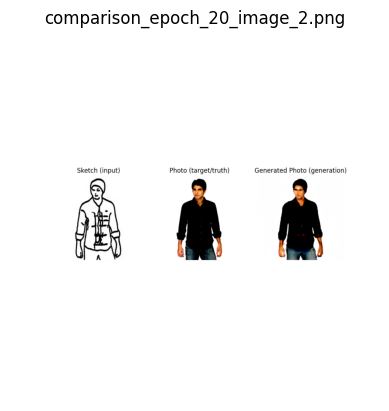

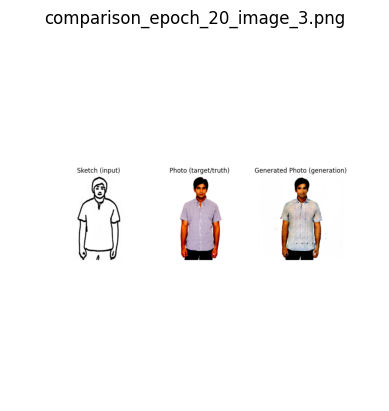

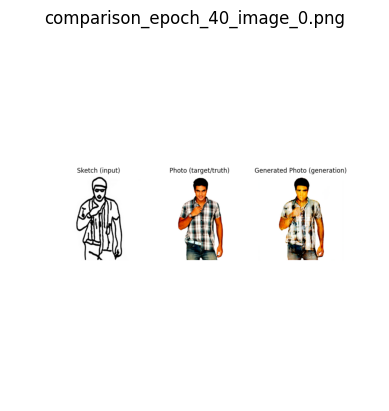

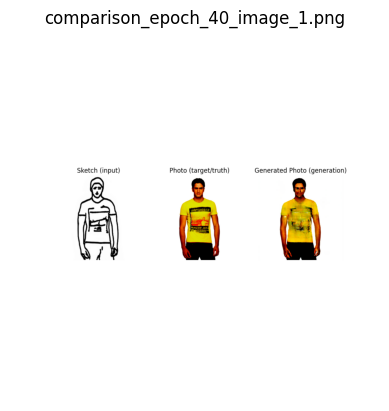

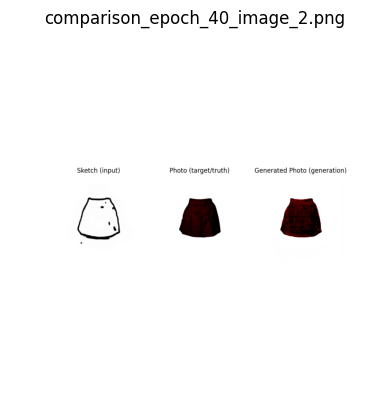

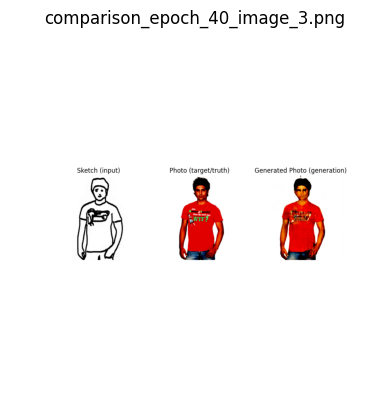

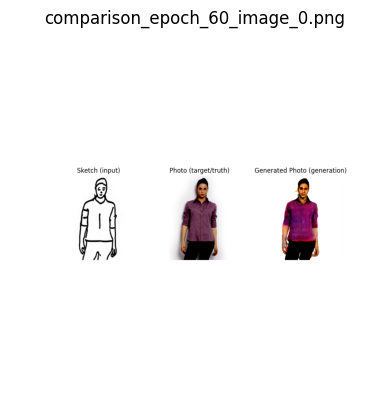

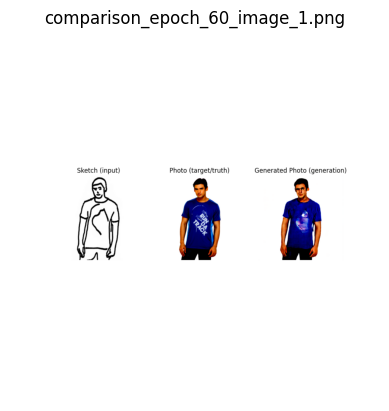

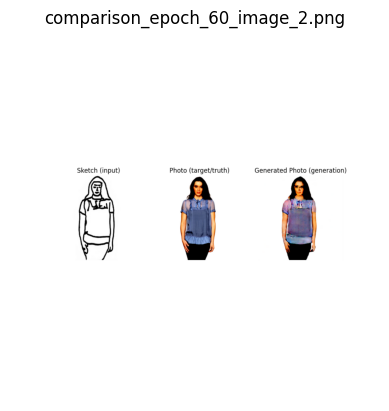

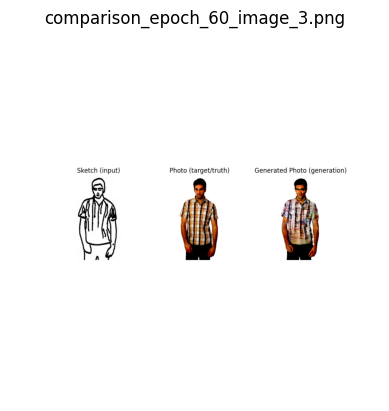

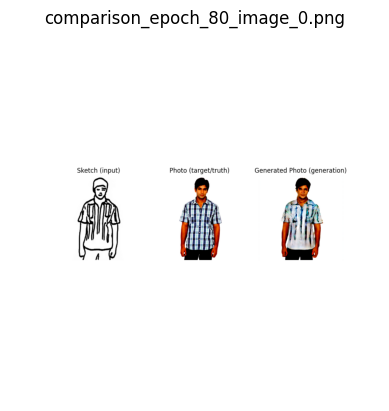

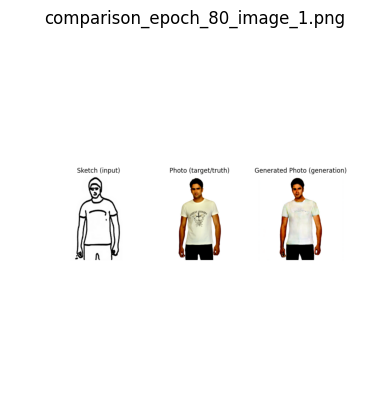

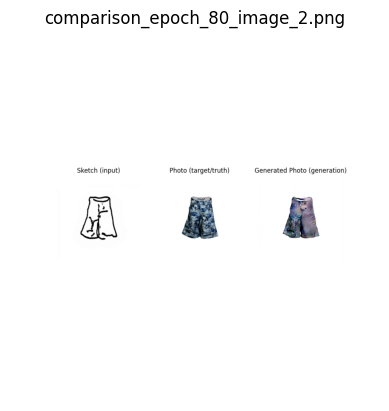

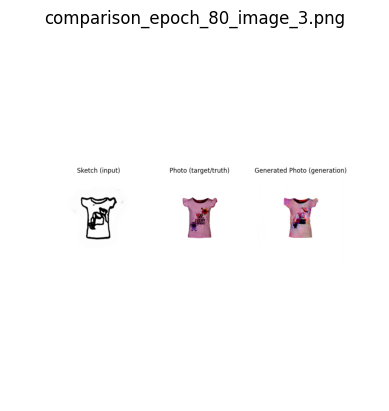

In [12]:
# Visualizar los resultados de entrenamiento algunas epocas

for i in range(0, EPOCHS, 20):
    # Cargar imagenes de {LOG_FOLDER}/train_images/comparison_epoch_{i}_image_{j}.png
    # y mostrarlas
    pattern = f"{LOG_FOLDER}/train_images/comparison_epoch_{i}_image_*.png"
    file_path_list = glob.glob(pattern)
    file_path_list.sort()
    for file_path in file_path_list:
        image = plt.imread(file_path)
        plt.imshow(image)
        plt.title(file_path.split('/')[-1])  # Muestra el nombre del archivo como título
        plt.axis('off')
        plt.show()  


In [13]:
# Ejecutarlo sobre los datos de test

def save_prediction(generator_model, sketch_image, save_path, photo_image=None):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))

    # Generar predicción
    generated_image = generator_model(sketch_image, training=False)
    plt.figure(figsize=(10, 10))

    if photo_image is not None:
        # Si photo_image está disponible, mostrar las tres imágenes
        images = [sketch_image[0], photo_image[0], generated_image[0]]
        titles = ['Sketch (input)', 'Photo (target/truth)', 'Generated Photo (generation)']
        num_images = 3
    else:
        # Si no, mostrar solo sketch_image y generated_image
        images = [sketch_image[0], generated_image[0]]
        titles = ['Sketch (input)', 'Generated Photo (generation)']
        num_images = 2

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.title(titles[i])

        plt.imshow(images[i].numpy())  # Para imágenes en el rango [0, 1]
        plt.axis('off')

    plt.savefig(save_path)


for i, (sketch_image, photo_image) in test_dataset.enumerate():
    save_prediction(generator_trained, sketch_image, 
                    f"{LOG_FOLDER}/test_images/prediction_{i}.png", 
                    photo_image)


# Visualizar algunos resultados de test

pattern = f"{LOG_FOLDER}/test_images/prediction_*.png"
file_path_list = glob.glob(pattern)
test_path_for_show = random.sample(file_path_list, 10)

for file_path in test_path_for_show:
    image = plt.imread(file_path)
    plt.imshow(image)
    plt.title(file_path.split('/')[-1])  # Muestra el nombre del archivo como título
    plt.axis('off')
    plt.show()  


2024-01-28 22:04:52.477087: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255